# Simple GP Regression 

Gaussian processes are a powerful tool for nonlinear regression models. 

Assume that we have **predictor** variables $\mathbf{X} = \{\mathbf{x_i}\}_{i=1}^N \in \mathbb{R}^d$ and **response** variables $\mathbf{y}=\{y_i \in \mathbb{R}\}_{i=1}^N$.

The response variables $\mathbf{y}$ are assumed to dependent on the predictors $\mathbf{X}$,

\begin{equation}
y_i \sim \mathcal{N}(f(\mathbf{x}_i),\sigma^2), \ i=1,\ldots,n,  
\end{equation}

where $f$ is a mapping function. Treating $f$ as a random function, we assume that the distribution over $f$ is a **Gaussian process**,
$$
f \sim \mathcal{GP}(m(\mathbf{x}),k(\mathbf{x},\mathbf{x}')),
$$
where $m(\cdot)$ and $k(\cdot,\cdot)$ are the mean and kernel functions respectively.

## 1D regression example

We start by simulating some data

In [1]:
using GaussianProcesses

srand(20140430)
# Training data
n=10;                          #number of training points
x = 2π * rand(n);              #predictors
y = sin.(x) + 0.05*randn(n);    #regressors

The first step in modelling with Gaussian Processes is to choose mean functions and kernels which describe the process. 

**Note** that all hyperparameters for the **mean** and **kernel** functions and $\sigma$ are given on the log scale. This is true for all strictly positive hyperparameters. Gaussian Processes are represented by objects of type 'GP' and constructed from observation data, a mean function and kernel, and optionally the amount of observation noise.

In [2]:
#Select mean and covariance function
mZero = MeanZero()                   #Zero mean function
kern = SE(0.0,0.0)                   #Sqaured exponential kernel (note that hyperparameters are on the log scale)

logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
gp = GP(x,y,mZero,kern,logObsNoise)       #Fit the GP

GP Exact object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]
  Input observations = 
[4.85461 5.17653 … 1.99412 3.45676]
  Output observations = [-0.967293, -1.00705, -1.0904, 0.881121, -0.333213, -0.976965, 0.915934, 0.736218, 0.950849, -0.306432]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -6.335

Once we've fit the `GP` function to the data, we can calculate the **predicted mean** and **variance** of of the function at unobserved points $\{\mathbf{x}^\ast,y^\ast\}$, conditional on the observed data $\mathcal{D}=\{\mathbf{y},\mathbf{X}\}$. This is done with the `predict_y` function.

The `predict_y` function returns the mean vector $\mu(\mathbf{x}^\ast)$ and covariance matrix (variance vector if `full_cov=false`) $\Sigma(\mathbf{x}^\ast,\mathbf{x}^{\ast^\top})$ of the predictive distribution,
\begin{equation}
    y^\ast|\mathbf{x}^\ast,\mathcal{D} \sim \mathcal{N}(\mu(\mathbf{x}^\ast),\Sigma(\mathbf{x}^\ast,\mathbf{x}^{\ast^\top})+\sigma^2\mathbf{I}),
\end{equation}
where 
\begin{eqnarray}
\mu(\mathbf{x}^\ast) &=& k(\mathbf{x}^\ast,\mathbf{X})(k(\mathbf{X}, \mathbf{X}) + \sigma_n^2 \mathbf{I})^{-1}\mathbf{y} \\ \ \mbox{and} \
\Sigma(\mathbf{x}^\ast,\mathbf{x}^{\ast}) &=& k(\mathbf{x}^\ast,\mathbf{x}^\ast) -k(\mathbf{x}^\ast,\mathbf{X})(k(\mathbf{X}, \mathbf{X})+ \sigma_n^2 \mathbf{I})^{-1} k(\mathbf{X},\mathbf{x}^\ast).
\end{eqnarray}

**Note** you can use the `predict_f` function to predict the latent function $\mathbf{f}^\ast$.

In [3]:
μ, σ² = predict_y(gp,linspace(0,2π,100));

Plotting GPs is straightforward and utilises the recipes approach to plotting from the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package. More information about plotting GPs and the available functionality can be found in this [notebook](https://github.com/STOR-i/GaussianProcesses.jl/blob/master/notebooks/Plotting%20GPs.ipynb).

The default plot function `plot(gp)` outputs the predicted mean and variance of the function (i.e. uses `predict_f` in the background), with the uncertainty in the function represented by a confidence ribbon (set to 95% by default). All optional plotting arguments are given after `;`.


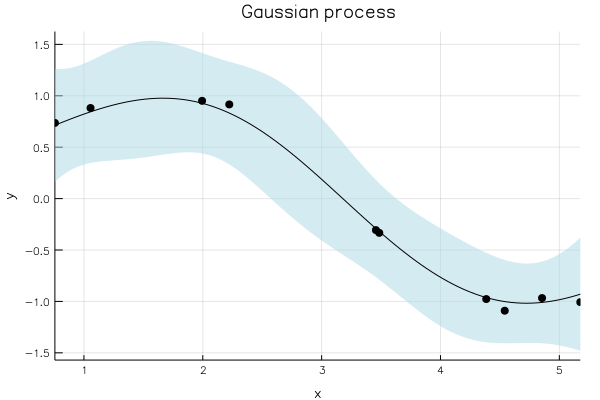

In [4]:
using Plots  #Load Plots.jl package

plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=false, fmt=:png)      # Plot the GP

The hyperparameters are optimized using the [Optim.jl](https://github.com/JuliaOpt/Optim.jl) package. This offers users a range of optimization algorithms which can be applied to estimate the hyperparameters using type II maximum likelihood estimation. Gradients are available for all mean and kernel functions used in the package and therefore it is recommended that the user utilizes gradient based optimization techniques. As a default, the `optimize!` function uses the `L-BFGS` solver, however, alternative solvers can be applied. 

In [5]:
optimize!(gp; method=Optim.BFGS())   # Optimise the hyperparameters

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [-1.0,0.0,0.0]
 * Minimizer: [-2.994848939774499,0.46368611846372537, ...]
 * Minimum: -3.275745e+00
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 42
 * Gradient Calls: 42

In [6]:
plot(gp)   #Plot the GP after the hyperparameters have been optimised 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 5 
 
 
 -1.0 
 
 
 -0.5 
 
 
 0.0 
 
 
 0.5 
 
 
 1.0 
 
<polygon clip-path="url(#clip8402)" points="
39.1436,93.2583 44.61,88.6111 50.0763,84.3664 55.5427,80.5227 61.0091,77.0522 66.4755,73.9068 71.9419,71.0305 77.4082,68.3718 82.8746,65.8899 88.341,63.5568 
 93.8074,61.3561 99.2737,59.2805 104.74,57.33 110.206,55.5099 115.673,53.8293 121.139,52.3002 126.606,50.9371 132.072,49.7556 137.538,48.773 143.005,48.007 
 148.471,47.4761 153.938,47.199 159.404,47.1946 164.87,47.4814 170.337,48.0774 175.803,48.9994 181.269,50.2628 186.736,51.8807 192.202,53.8633 197.669,56.2176 
 203.135,58.9464 208.601,62.0486 214.068,65.5189 219.534,69.3486 225,73.5256 230.467,78.0356 235.933,82.8626 241.4,87.9892 246.866,93.3976 252.332,99.0694 
 257.799,104.986 263.265,111.13 268.731,117.483 274.198,124.026 279.664,130.742 285.131,137.614 290.597,144.624 296.063,151.755 301.53,158.99 306.996,166.313 
 312.462,173.709 317.929,181.16 323.395,188.652 328.862,196.168 334.328,203.696 339.794,211.218 345.261,218.722 350.727,226.193 356.193,233.616 361.66,240.978 
 367.126,248.264 372.593,255.459 378.059,262.549 383.525,269.517 388.992,276.349 394.458,283.028 399.925,289.537 405.391,295.86 410.857,301.98 416.324,307.882 
 421.79,313.549 427.256,318.966 432.723,324.121 438.189,329 443.656,333.592 449.122,337.888 454.588,341.879 460.055,345.56 465.521,348.924 470.987,351.97 
 476.454,354.694 481.92,357.098 487.387,359.184 492.853,360.955 498.319,362.418 503.786,363.581 509.252,364.456 514.718,365.056 520.185,365.401 525.651,365.511 
 531.118,365.414 536.584,365.139 542.05,364.718 547.517,364.185 552.983,363.573 558.449,362.91 563.916,362.22 569.382,361.52 574.849,360.825 580.315,360.143 
 580.315,333.077 574.849,336.199 569.382,338.98 563.916,341.409 558.449,343.475 552.983,345.174 547.517,346.509 542.05,347.486 536.584,348.117 531.118,348.417 
 525.651,348.4 520.185,348.077 514.718,347.46 509.252,346.555 503.786,345.366 498.319,343.897 492.853,342.148 487.387,340.12 481.92,337.812 476.454,335.223 
 470.987,332.353 465.521,329.202 460.055,325.768 454.588,322.054 449.122,318.059 443.656,313.785 438.189,309.234 432.723,304.408 427.256,299.312 421.79,293.95 
 416.324,288.326 410.857,282.447 405.391,276.32 399.925,269.954 394.458,263.359 388.992,256.547 383.525,249.533 378.059,242.331 372.593,234.959 367.126,227.436 
 361.66,219.783 356.193,212.022 350.727,204.176 345.261,196.27 339.794,188.328 334.328,180.375 328.862,172.436 323.395,164.536 317.929,156.7 312.462,148.951 
 306.996,141.312 301.53,133.806 296.063,126.454 290.597,119.276 285.131,112.29 279.664,105.513 274.198,98.9601 268.731,92.6458 263.265,86.5814 257.799,80.7768 
 252.332,75.2396 246.866,69.9755 241.4,64.9882 235.933,60.2792 230.467,55.8484 225,51.694 219.534,47.8133 214.068,44.2028 208.601,40.8596 203.135,37.7811 
 197.669,34.9664 192.202,32.4163 186.736,30.1335 181.269,28.1226 175.803,26.3892 170.337,24.94 164.87,23.7817 159.404,22.9208 153.938,22.363 148.471,22.113 
 143.005,22.1739 137.538,22.5474 132.072,23.2335 126.606,24.2303 121.139,25.5339 115.673,27.1382 110.206,29.0346 104.74,31.2113 99.2737,33.6534 93.8074,36.341 
 88.341,39.2488 82.8746,42.3439 77.4082,45.584 71.9419,48.9151 66.4755,52.2708 61.0091,55.5736 55.5427,58.7421 50.0763,61.7031 44.61,64.404 39.1436,66.8193 
 
 " fill="#add8e6" fill-opacity="0.5"/>
<polyline clip-path="url(#clip8402)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 39.1436,80.0388 44.61,76.5076 50.0763,73.0348 55.5427,69.6324 61.0091,66.3129 66.4755,63.0888 71.9419,59.9728 77.4082,56.9779 82.8746,54.1169 88.341,51.4028 
 93.8074,48.8486 99.2737,46.467 104.74,44.2707 110.206,42.2722 115.673,40.4837 121.139,38.9171 126.606,37.5837 132.072,36.4946 137.538,35.6602 143.005,35.0904 
 148.471,34.7945 153.938,34.781 159.404,35.0577 164.87,35.6316 170.337,36.5087 175.803,37.6943 181.26

MCMC can be run on the GPE hyperparameters through the `mcmc` function. Priors for hyperparameters of the mean and kernel parameters can be set through the `set_priors!` function. The log noise parameter of the GPE is a Uniform(0,1) distribution and currently can't be changed.

In [7]:
using Distributions

set_priors!(kern, [Normal(), Normal()]) # Uniform(0,1) distribution assumed by default if priors not specified
chain = mcmc(gp)
plot(chain', label=["Noise", "SE log length", "SE log scale"])

Number of iterations = 1000, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 10.048000 
Number of function calls: 10049
Acceptance rate: 0.968000 


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 1000 
 
 
 -3 
 
 
 -2 
 
 
 -1 
 
 
 0 
 
 
 1 
 
<polyline clip-path="url(#clip8602)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.2591,337.026 29.8108,336.206 30.3624,350.244 30.914,302.011 31.4656,322.547 32.0172,343.433 32.5688,343.433 33.1204,315.721 33.672,346.48 34.2236,316.705 
 34.7752,331.263 35.3268,328.926 35.8784,338.198 36.43,331.295 36.9816,353.255 37.5333,337.776 38.0849,319.909 38.6365,357.762 39.1881,294.118 39.7397,321.509 
 40.2913,339.858 40.8429,317.225 41.3945,311.167 41.9461,358.327 42.4977,278.548 43.0493,337.967 43.6009,312.49 44.1525,358.075 44.7042,321.488 45.2558,321.967 
 45.8074,252.641 46.359,346.115 46.9106,278.218 47.4622,341.477 48.0138,302.736 48.5654,316.056 49.117,286.67 49.6686,322.17 50.2202,323.058 50.7718,351.25 
 51.3234,303.418 51.875,350.574 52.4267,314.938 52.9783,309.178 53.5299,348.812 54.0815,309.921 54.6331,348.332 55.1847,319.875 55.7363,342.219 56.2879,316.922 
 56.8395,341.742 57.3911,322.694 57.9427,345.048 58.4943,322.187 59.0459,343.174 59.5976,316.259 60.1492,344.848 60.7008,321.416 61.2524,341.668 61.804,329.145 
 62.3556,346.352 62.9072,324.214 63.4588,339.116 64.0104,347.042 64.562,361.74 65.1136,294.693 65.6652,326.567 66.2168,329.271 66.7684,336.199 67.3201,331.15 
 67.8717,336.981 68.4233,346.984 68.9749,331.339 69.5265,334.528 70.0781,330.936 70.6297,350.336 71.1813,317.073 71.7329,349.545 72.2845,320.338 72.8361,342.698 
 73.3877,342.698 73.9393,322.819 74.491,334.91 75.0426,354.289 75.5942,309.406 76.1458,368.766 76.6974,304.2 77.249,345.189 77.8006,303.504 78.3522,316.445 
 78.9038,342.383 79.4554,287.371 80.007,364.576 80.5586,318.259 81.1102,318.259 81.6618,350.791 82.2135,330.214 82.7651,326.999 83.3167,327.204 83.8683,324.21 
 84.4199,327.954 84.9715,334.527 85.5231,304.161 86.0747,352.033 86.6263,310.149 87.1779,340.834 87.7295,331.296 88.2811,330.465 88.8327,339.108 89.3844,324.385 
 89.936,346.396 90.4876,321.806 91.0392,294.746 91.5908,360.61 92.1424,292.522 92.694,348.803 93.2456,319.733 93.7972,302.737 94.3488,302.736 94.9004,341.812 
 95.452,363.612 96.0036,305.095 96.5552,335.502 97.1069,297.163 97.6585,354.787 98.2101,304.202 98.7617,332.104 99.3133,310.612 99.8649,350.069 100.417,308.884 
 100.968,310.806 101.52,313.41 102.071,362.73 102.623,309.857 103.175,332.834 103.726,326.417 104.278,338.502 104.829,317.771 105.381,282.156 105.933,375.813 
 106.484,306.953 107.036,317.796 107.587,339.817 108.139,329.534 108.691,339.197 109.242,324.646 109.794,347.598 110.345,300.571 110.897,353.633 111.449,313.627 
 112,311.173 112.552,343.171 113.103,301.998 113.655,310.247 114.207,329.244 114.758,325.265 115.31,344.933 115.862,323.14 116.413,301.933 116.965,346.684 
 117.516,325.733 118.068,342.22 118.62,319.35 119.171,342.449 119.723,320.488 120.274,344.768 120.826,287.439 121.378,366.114 121.929,276.65 122.481,335.146 
 123.032,339.436 123.584,330.42 124.136,334.7 124.687,336.14 125.239,319.336 125.79,337.311 126.342,319.221 126.894,296.755 127.445,347.779 127.997,311.894 
 128.548,334.659 129.1,329.174 129.652,306.471 130.203,330.971 130.755,310.885 131.307,306.512 131.858,355.076 132.41,339.854 132.961,275.166 133.513,321.142 
 134.065,347.251 134.616,324.047 135.168,334.67 135.719,316.664 136.271,341.795 136.823,331.808 137.374,333.126 137.926,332.228 138.477,348.976 139.029,318.633 
 139.581,343.145 140.132,342.418 140.684,302.895 141.235,346.864 141.787,332.722 142.339,312.813 142.89,333.824 143.442,331.441 143.993,313.268 144.545,318.279 
 145.097,336.237 145.648,310.204 146.2,341.13 146.752,341.13 147.303,323.496 147.855,340.236 148.406,305.735 148.958,317.54 149.51,297.271 150.061,329.808 
 150.613,353.006 151.164,304.388 151.716,313.136 152.268,348.267 152.819,318.806 153.371,335.466 153.922,317.061 154.474,332.569 155.026,306.871 155.577,353.335 
 15

## Multi-dimensional regression

The regression example above can be easily extended to higher dimensions. For the purpose of visualisation, and without loss of generality, we consider a 2 dimensional regression example.

In [8]:
#Training data
d, n = 2, 50;         #Dimension and number of observations
x = 2π * rand(d, n);                               #Predictors
y = vec(sin.(x[1,:]).*sin.(x[2,:])) + 0.05*rand(n);  #Responses

For problems of dimension>1 we can use isotropic (`Iso`) kernels or automatic relevance determination (`ARD`) kernels. For `Iso` kernels, the length scale parameter $\ell$ is the same for all dimensions. For `ARD` kernels, each dimension has different length scale parameter.

The `Iso` and `ARD` kernels are implemented automatically by replacing the single length scale parameter with a vector of parameters. For example, below we use the Matern 5/2 `ARD` kernel, if we wanted to use the `Iso` alternative then we would set the kernel as `kern=Mat(5/2,0.0,0.0)`.

In this example we use a composite kernel represented as the sum of a Matern 5/2 ARD kernel and a Squared Exponential isotropic kernel. This is easily implemented using the `+` symbol, or in the case of a product kernel, using the `*` symbol (i.e. `kern = Mat(5/2,[0.0,0.0],0.0) * SE(0.0,0.0)`).

In [9]:
mZero = MeanZero()                             # Zero mean function
kern = Matern(5/2,[0.0,0.0],0.0) + SE(0.0,0.0)    # Sum kernel with Matern 5/2 ARD kernel 
                                               # with parameters [log(ℓ₁), log(ℓ₂)] = [0,0] and log(σ) = 0
                                               # and Squared Exponential Iso kernel with
                                               # parameters log(ℓ) = 0 and log(σ) = 0

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.Mat52Ard, Params: [-0.0, -0.0, 0.0]
  Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]


Fit the Gaussian process to the data using the prespecfied mean and covariance functions.

In [10]:
gp = GP(x,y,mZero,kern,-2.0)          # Fit the GP

GP Exact object:
  Dim = 2
  Number of observations = 50
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.SumKernel
      Type: GaussianProcesses.Mat52Ard, Params: [-0.0, -0.0, 0.0]
      Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]
  Input observations = 
[2.74893 2.46934 … 5.12901 2.319; 0.590648 0.483535 … 5.75726 2.98108]
  Output observations = [0.236454, 0.332526, -0.237103, 0.622928, 0.0100444, -0.188826, -0.793395, 0.111517, 0.517965, 0.505019  …  0.663763, -0.0444821, -0.0833567, 0.250078, 0.916791, -0.314351, -0.549614, 0.491283, 0.480076, 0.136957]
  Variance of observation noise = 0.01831563888873418
  Marginal Log-Likelihood = -30.219

Using the [Optim](https://github.com/JuliaOpt/Optim.jl) package we have the option to choose from a range of optimize functions including conjugate gradients. It is also possible to fix the hyperparameters in either the mean function, kernel function or observation noise, by settting them to false in `optimize!` (e.g. `optimize!(...,domean=false)`).

In [11]:
optimize!(gp)                         # Optimize the hyperparameters

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-2.0,-0.0,-0.0,0.0,0.0,0.0]
 * Minimizer: [-18.24475506605094,0.025983780365091583, ...]
 * Minimum: -5.600783e+01
 * Iterations: 57
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 229
 * Gradient Calls: 229

A range of plotting options are availbe through the [Plots.jl](https://github.com/JuliaPlots/Plots.jl) package.

In [12]:
plot(contour(gp) ,heatmap(gp))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 5 
 
 
 6 
 
 
 1 
 
 
 2 
 
 
 3 
 
 
 4 
 
 
 5 
 
 
 6 
 
 
 
<polyline clip-path="url(#clip8802)" style="stroke:#e65e2d; stroke-width:1; stroke-opacity:1; fill:none" points="
 22.3377,309.411 25.0426,316.384 26.378,319.401 28.3803,323.813 30.4184,327.854 32.2114,331.242 34.4587,335.172 36.6085,338.67 38.4991,341.605 41.6872,346.099 
 42.5394,347.278 46.5798,352.296 47.7123,353.528 50.6201,356.719 54.6605,360.46 55.2987,360.956 58.7008,363.704 62.7412,366.3 66.7815,368.258 67.1627,368.385 
 70.8219,369.71 74.8623,370.504 78.9026,370.598 82.943,369.911 86.7462,368.385 86.9833,368.291 91.0237,365.655 95.064,361.357 95.3353,360.956 99.1044,354.697 
 99.6112,353.528 102.361,346.099 103.145,343.618 104.383,338.67 106.045,331.242 107.185,325.359 107.437,323.813 108.509,316.384 109.359,308.956 110.016,301.527 
 110.519,294.099 110.9,286.67 111.184,279.241 111.225,277.641 111.367,271.813 111.43,264.384 111.306,256.956 111.225,255.443 110.868,249.527 109.996,242.098 
 108.554,234.67 107.185,229.942 106.186,227.241 103.145,221.419 101.982,219.812 99.1044,216.685 95.064,213.697 92.5109,212.384 91.0237,211.713 86.9833,210.396 
 82.943,209.508 78.9026,208.931 74.8623,208.592 70.8219,208.442 66.7815,208.45 62.7412,208.593 58.7008,208.858 54.6605,209.235 50.6201,209.718 46.5798,210.31 
 42.5394,211.024 38.4991,211.887 36.4929,212.384 34.4587,212.997 30.4184,214.472 26.378,216.457 22.3377,219.295 
 "/>
<polyline clip-path="url(#clip8802)" style="stroke:#d24742; stroke-width:1; stroke-opacity:1; fill:none" points="
 22.3377,192.49 26.378,194.664 30.4184,196.156 34.4587,197.197 36.1775,197.527 38.4991,197.938 42.5394,198.454 46.5798,198.795 50.6201,199.008 54.6605,199.133 
 58.7008,199.202 62.7412,199.242 66.7815,199.273 70.8219,199.313 74.8623,199.378 78.9026,199.488 82.943,199.67 86.9833,199.964 91.0237,200.426 95.064,201.151 
 99.1044,202.306 103.145,204.209 104.227,204.955 107.185,207.443 110.58,212.384 111.225,213.686 113.344,219.812 114.893,227.241 115.266,229.939 115.8,234.67 
 116.328,242.098 116.594,249.527 116.653,256.956 116.561,264.384 116.387,271.813 116.185,279.241 115.978,286.67 115.76,294.099 115.512,301.527 115.266,307.631 
 115.207,308.956 114.814,316.384 114.333,323.813 113.777,331.242 113.197,338.67 112.644,346.099 112.059,353.528 111.311,360.956 111.225,361.707 110.23,368.385 
 108.705,375.813 
 "/>
<polyline clip-path="url(#clip8802)" style="stroke:#ba3655; stroke-width:1; stroke-opacity:1; fill:none" points="
 128.768,375.813 127.387,372.678 125.913,368.385 124.02,360.956 123.346,357.48 122.703,353.528 121.79,346.099 121.216,338.67 120.915,331.242 120.78,323.813 
 120.724,316.384 120.702,308.956 120.706,301.527 120.742,294.099 120.827,286.67 120.977,279.241 121.199,271.813 121.475,264.384 121.767,256.956 122.037,249.527 
 122.277,242.098 122.504,234.67 122.754,227.241 123.092,219.812 123.346,216.122 123.685,212.384 125.082,204.955 127.387,200.199 130.025,197.527 131.427,196.653 
 135.468,195.05 139.508,194.143 143.548,193.584 147.589,193.223 151.629,192.986 155.669,192.827 159.71,192.72 163.75,192.646 167.79,192.593 171.831,192.551 
 175.871,192.515 179.911,192.482 183.952,192.452 187.992,192.429 192.032,192.419 196.073,192.437 200.113,192.505 204.154,192.663 208.194,192.989 212.234,193.651 
 216.275,195.112 219.16,197.527 220.315,199.48 
 "/>
<polyline clip-path="url(#clip8802)" style="stroke:#d24742; stroke-width:1; stroke-opacity:1; fill:none" points="
 220.315,121.062 220.133,123.24 219.432,130.669 218.692,138.098 217.885,145.526 216.684,152.955 216.275,154.721 214.761,160.383 212.234,166.499 211.558,167.812 
 208.194,172.542 205.484,175.241 204.154,176.266 200.113,178.709 196.073,180.449 192.032,181.723 187.992,182.665 187.97,182.669 183.952,183.338 179.911,183.818 
 175.871,184.136 171.831,184.311 167.79,184.354 163.75,184.269 159.71,184.05 155.669,183.6